# IT Support Interactions Analytics

This notebook demonstrates SQL-based analytics on IT support interaction data using a star schema data warehouse.

**Key Metrics Explored:**
- Daily/weekly interaction volume trends
- Location-based support demand
- Technician workload distribution
- IMS to Incident conversion rates
- State/resolution analysis

In [3]:
# Setup: Import libraries and connect to database
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Connect to database
DB_PATH = Path("interactions.db")
conn = sqlite3.connect(DB_PATH)

print(f"✅ Connected to: {DB_PATH}")
print(f"📊 Database size: {DB_PATH.stat().st_size / 1024 / 1024:.2f} MB")

✅ Connected to: interactions.db
📊 Database size: 9.20 MB


## 1. Database Overview

First, let's examine our star schema structure and row counts.

In [4]:
# Query table statistics
schema_stats = """
SELECT 'dim_users' as table_name, COUNT(*) as row_count FROM dim_users
UNION ALL SELECT 'dim_technicians', COUNT(*) FROM dim_technicians
UNION ALL SELECT 'dim_locations', COUNT(*) FROM dim_locations
UNION ALL SELECT 'dim_states', COUNT(*) FROM dim_states
UNION ALL SELECT 'dim_dates', COUNT(*) FROM dim_dates
UNION ALL SELECT 'fact_interactions', COUNT(*) FROM fact_interactions
UNION ALL SELECT 'bridge_ims_inc', COUNT(*) FROM bridge_ims_inc
"""

df_stats = pd.read_sql_query(schema_stats, conn)
df_stats.style.bar(subset=['row_count'], color='#5fba7d')

,table_name,row_count
0,dim_users,10240
1,dim_technicians,24
2,dim_locations,18
3,dim_states,3
4,dim_dates,84
5,fact_interactions,19294
6,bridge_ims_inc,15818


## 2. Daily Interactions Trend

Analyze daily ticket volume to identify patterns and peak support days.

In [5]:
daily_trend = """
SELECT 
    d.full_date,
    d.day_name,
    d.is_weekend,
    COUNT(*) as interactions
FROM fact_interactions f
JOIN dim_dates d ON f.opened_date_id = d.date_id
GROUP BY d.date_id
ORDER BY d.full_date DESC
LIMIT 30
"""

df_daily = pd.read_sql_query(daily_trend, conn)
df_daily['full_date'] = pd.to_datetime(df_daily['full_date'])
df_daily

,full_date,day_name,is_weekend,interactions
0,2025-12-18,Thursday,0,282
1,2025-12-17,Wednesday,0,185
2,2025-12-16,Tuesday,0,315
3,2025-12-15,Monday,0,411
4,2025-12-12,Friday,0,175
5,2025-12-11,Thursday,0,233
6,2025-12-10,Wednesday,0,253
7,2025-12-09,Tuesday,0,227
8,2025-12-08,Monday,0,247
9,2025-12-05,Friday,0,171


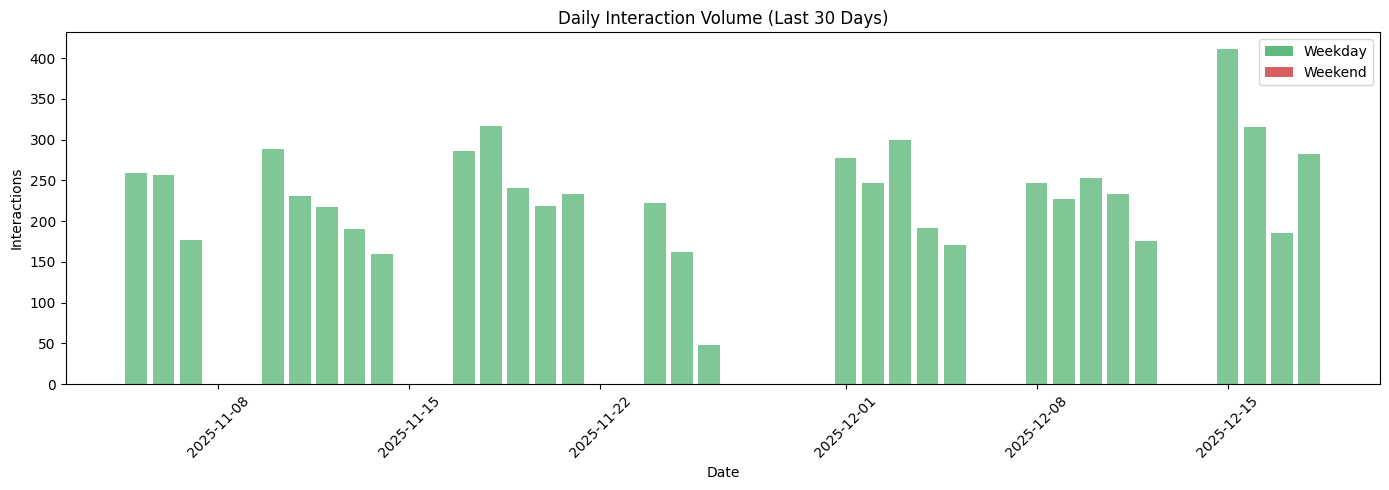

In [6]:
# Visualize daily trend
fig, ax = plt.subplots(figsize=(14, 5))

colors = ['#d65f5f' if w else '#5fba7d' for w in df_daily['is_weekend']]
ax.bar(df_daily['full_date'], df_daily['interactions'], color=colors, alpha=0.8)

ax.set_xlabel('Date')
ax.set_ylabel('Interactions')
ax.set_title('Daily Interaction Volume (Last 30 Days)')
ax.tick_params(axis='x', rotation=45)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#5fba7d', label='Weekday'),
                   Patch(facecolor='#d65f5f', label='Weekend')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## 3. Interactions by Location

Identify which office locations generate the most support requests.

In [7]:
location_query = """
SELECT 
    l.location_name,
    COUNT(*) as total_interactions,
    COUNT(DISTINCT f.tech_id) as unique_technicians,
    ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT f.opened_date_id), 1) as avg_daily
FROM fact_interactions f
JOIN dim_locations l ON f.location_id = l.location_id
GROUP BY f.location_id
ORDER BY total_interactions DESC
"""

df_location = pd.read_sql_query(location_query, conn)
df_location.style.bar(subset=['total_interactions'], color='#5fba7d')

,location_name,total_interactions,unique_technicians,avg_daily
0,1700 SE 5TH ST,5800,19,78.400000
1,811 EXCELLENCE,3296,12,49.200000
2,805 MOBERLY LN,2337,10,31.200000
3,2608 SE J Street,2327,8,32.300000
4,702 SW 8TH ST.,1967,11,63.500000
5,2101 SE SIMPLE SAVINGS DRIVE,1960,12,29.700000
6,703 ASSOCIATE DR,884,6,26.000000
7,805 RESPECT,405,5,101.300000
8,2403 SE J ST,70,2,35.000000
9,2914 SE I ST,66,6,4.400000


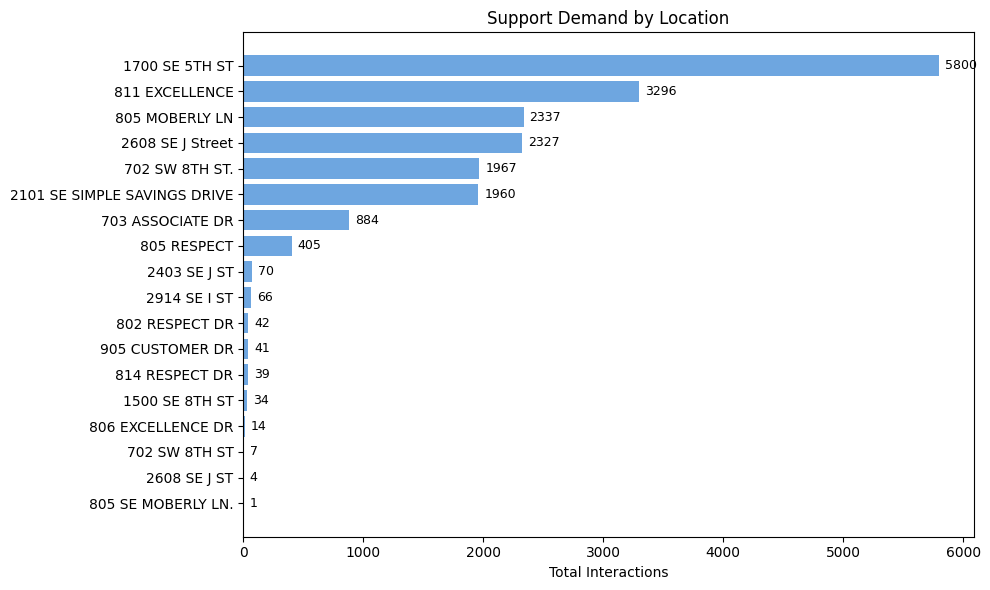

In [8]:
# Horizontal bar chart for locations
fig, ax = plt.subplots(figsize=(10, 6))

y_pos = range(len(df_location))
ax.barh(y_pos, df_location['total_interactions'], color='#4a90d9', alpha=0.8)
ax.set_yticks(y_pos)
ax.set_yticklabels(df_location['location_name'])
ax.invert_yaxis()  # Highest at top
ax.set_xlabel('Total Interactions')
ax.set_title('Support Demand by Location')

# Add value labels
for i, v in enumerate(df_location['total_interactions']):
    ax.text(v + 50, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 4. Technician Workload Analysis

Compare ticket volume and efficiency across support staff.

In [9]:
tech_workload = """
SELECT 
    t.tech_name,
    t.tech_id,
    COUNT(*) as total_tickets,
    COUNT(DISTINCT f.opened_date_id) as days_active,
    ROUND(COUNT(*) * 1.0 / COUNT(DISTINCT f.opened_date_id), 1) as avg_per_day,
    COUNT(DISTINCT f.location_id) as locations_served
FROM fact_interactions f
JOIN dim_technicians t ON f.tech_id = t.tech_id
GROUP BY f.tech_id
HAVING total_tickets >= 100
ORDER BY total_tickets DESC
"""

df_workload = pd.read_sql_query(tech_workload, conn)
df_workload.style.background_gradient(subset=['avg_per_day'], cmap='YlGn')

,tech_name,tech_id,total_tickets,days_active,avg_per_day,locations_served
0,Plas Abraham,pdabrah,2270,61,37.200000,1
1,Mason Montgomery,m0m187i,1665,50,33.300000,4
2,Daniel Menh,d0m0136,1610,51,31.600000,3
3,Kaleb Thompson,k1thomp,1574,66,23.800000,9
4,Jackie Phrakousonh,j0p0u94,1476,62,23.800000,9
5,Tessa Black,t0m07x1,1259,48,26.200000,4
6,Agustin Rodriguez,arod164,1244,61,20.400000,3
7,Marquis Elliott,mellio3,1228,62,19.800000,9
8,Anthony Clark,a0c01a7,1222,61,20.000000,5
9,Dillon Burch,dburch2,1157,64,18.100000,9


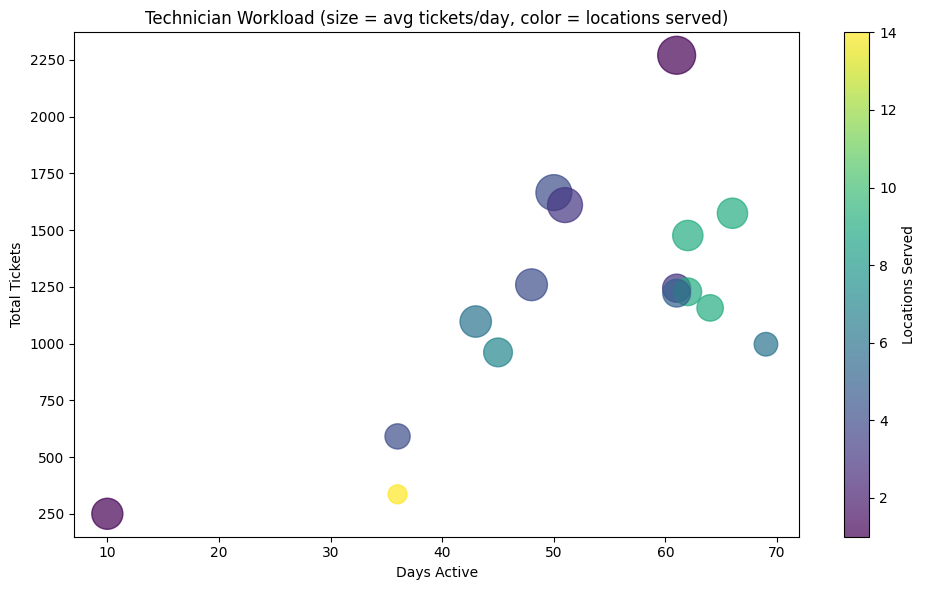

In [10]:
# Scatter plot: Total tickets vs Avg per day
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    df_workload['days_active'], 
    df_workload['total_tickets'],
    s=df_workload['avg_per_day'] * 20,  # Size by productivity
    c=df_workload['locations_served'],
    cmap='viridis',
    alpha=0.7
)

ax.set_xlabel('Days Active')
ax.set_ylabel('Total Tickets')
ax.set_title('Technician Workload (size = avg tickets/day, color = locations served)')

plt.colorbar(scatter, label='Locations Served')
plt.tight_layout()
plt.show()

## 5. Interaction State Distribution

Analyze ticket resolution status and identify bottlenecks.

In [11]:
state_distribution = """
SELECT 
    s.state_name,
    COUNT(*) as count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(), 2) as percentage
FROM fact_interactions f
JOIN dim_states s ON f.state_id = s.state_id
GROUP BY f.state_id
ORDER BY count DESC
"""

df_states = pd.read_sql_query(state_distribution, conn)
df_states

,state_name,count,percentage
0,Closed Complete,18456,95.66
1,Closed Abandoned,833,4.32
2,Work in Progress,5,0.03


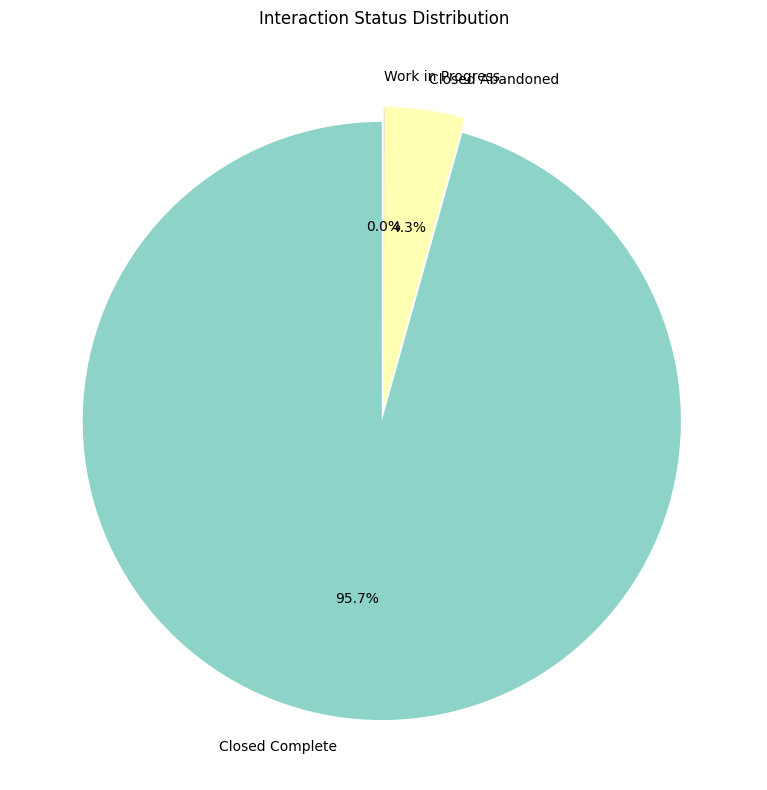

In [12]:
# Pie chart for state distribution
fig, ax = plt.subplots(figsize=(8, 8))

colors = plt.cm.Set3(range(len(df_states)))
explode = [0.05 if i == 0 else 0 for i in range(len(df_states))]

ax.pie(
    df_states['count'], 
    labels=df_states['state_name'],
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=90
)
ax.set_title('Interaction Status Distribution')
plt.tight_layout()
plt.show()

## 6. IMS to Incident Conversion Rate

Calculate how many interactions result in formal incident tickets.

In [13]:
conversion_rate = """
WITH tech_interactions AS (
    SELECT 
        f.tech_id,
        COUNT(DISTINCT f.interaction_number) as total_ims
    FROM fact_interactions f
    GROUP BY f.tech_id
),
tech_incidents AS (
    SELECT 
        b.created_by as tech_id,
        COUNT(DISTINCT b.incident_number) as total_incidents
    FROM bridge_ims_inc b
    WHERE b.incident_number IS NOT NULL
    GROUP BY b.created_by
)
SELECT 
    t.tech_name,
    ti.tech_id,
    ti.total_ims,
    COALESCE(inc.total_incidents, 0) as total_incidents,
    ROUND(100.0 * COALESCE(inc.total_incidents, 0) / ti.total_ims, 2) as conversion_pct
FROM tech_interactions ti
JOIN dim_technicians t ON ti.tech_id = t.tech_id
LEFT JOIN tech_incidents inc ON ti.tech_id = inc.tech_id
WHERE ti.total_ims >= 50
ORDER BY conversion_pct DESC
"""

df_conversion = pd.read_sql_query(conversion_rate, conn)
df_conversion.style.background_gradient(subset=['conversion_pct'], cmap='RdYlGn')

,tech_name,tech_id,total_ims,total_incidents,conversion_pct
0,Harrison Couch,h0c01en,997,793,79.540000
1,Dillon Burch,dburch2,1157,660,57.040000
2,Jackie Phrakousonh,j0p0u94,1476,802,54.340000
3,Jon Lowe,j0l0pjd,591,306,51.780000
4,Tessa Black,t0m07x1,1259,631,50.120000
5,Anthony Clark,a0c01a7,1222,610,49.920000
6,Kaleb Thompson,k1thomp,1574,749,47.590000
7,Agustin Rodriguez,arod164,1244,574,46.140000
8,Hasheema Ali,h0a005g,336,145,43.150000
9,Marquis Elliott,mellio3,1228,471,38.360000


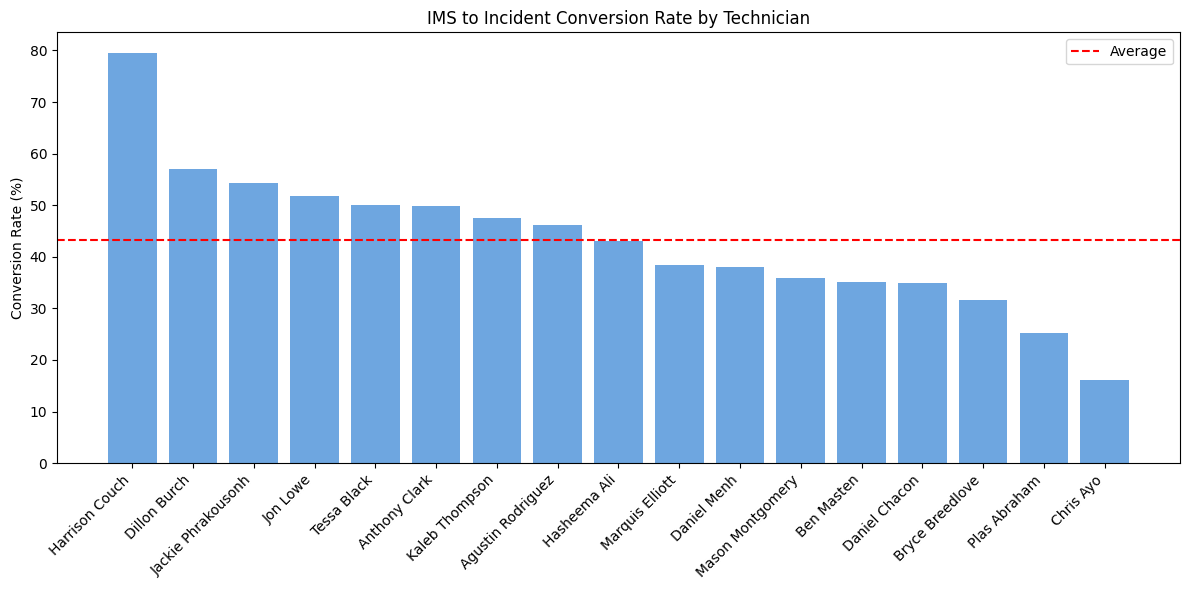

In [14]:
# Bar chart: Conversion rate by technician
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(df_conversion))
ax.bar(x, df_conversion['conversion_pct'], color='#4a90d9', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(df_conversion['tech_name'], rotation=45, ha='right')
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('IMS to Incident Conversion Rate by Technician')
ax.axhline(y=df_conversion['conversion_pct'].mean(), color='red', linestyle='--', label='Average')
ax.legend()

plt.tight_layout()
plt.show()

## 7. Weekly Patterns Analysis

Identify day-of-week patterns in support demand.

In [15]:
weekly_pattern = """
SELECT 
    d.day_of_week,
    d.day_name,
    COUNT(*) as total_interactions,
    ROUND(AVG(daily_count), 1) as avg_interactions
FROM (
    SELECT 
        opened_date_id,
        COUNT(*) as daily_count
    FROM fact_interactions
    GROUP BY opened_date_id
) daily
JOIN dim_dates d ON daily.opened_date_id = d.date_id
GROUP BY d.day_of_week
ORDER BY d.day_of_week
"""

df_weekly = pd.read_sql_query(weekly_pattern, conn)
df_weekly

,day_of_week,day_name,total_interactions,avg_interactions
0,0,Monday,18,263.2
1,1,Tuesday,18,232.4
2,2,Wednesday,16,248.3
3,3,Thursday,16,227.1
4,4,Friday,16,172.9


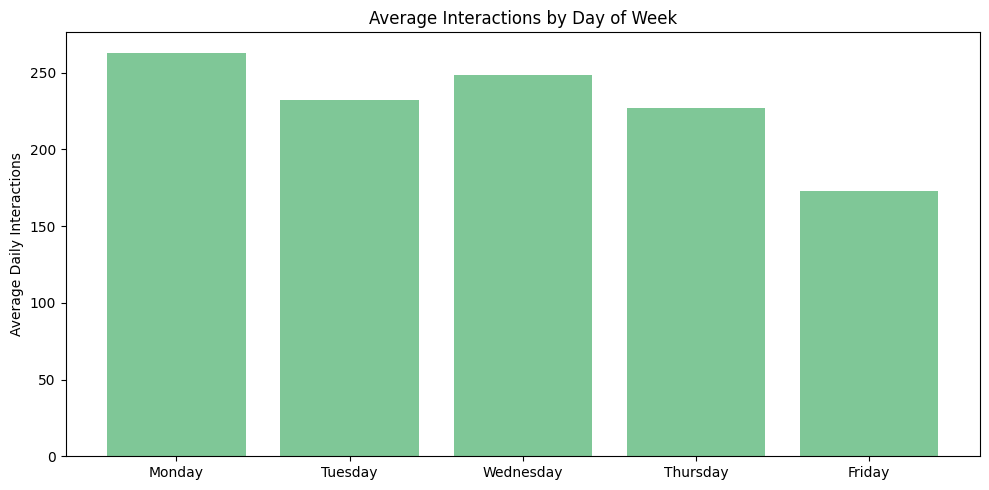

In [16]:
# Day of week bar chart
fig, ax = plt.subplots(figsize=(10, 5))

colors = ['#d65f5f' if dow >= 5 else '#5fba7d' for dow in df_weekly['day_of_week']]
ax.bar(df_weekly['day_name'], df_weekly['avg_interactions'], color=colors, alpha=0.8)

ax.set_ylabel('Average Daily Interactions')
ax.set_title('Average Interactions by Day of Week')

plt.tight_layout()
plt.show()

## 8. Interaction Type Analysis

Break down support requests by category.

In [17]:
type_analysis = """
SELECT 
    COALESCE(interaction_type, 'Unknown') as type,
    COUNT(*) as count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(), 2) as percentage
FROM fact_interactions
GROUP BY interaction_type
ORDER BY count DESC
"""

df_types = pd.read_sql_query(type_analysis, conn)
df_types.style.bar(subset=['count'], color='#4a90d9')

,type,count,percentage
0,Walk-up,19294,100.000000


## 9. Top Request Categories

Analyze the most common support request types based on short descriptions.

In [18]:
# Extract category from short_description (text before the |)
category_query = """
SELECT 
    TRIM(SUBSTR(short_description, 1, INSTR(short_description || '|', '|') - 1)) as category,
    COUNT(*) as count
FROM fact_interactions
WHERE short_description IS NOT NULL AND short_description != ''
GROUP BY category
HAVING count >= 100
ORDER BY count DESC
LIMIT 15
"""

df_categories = pd.read_sql_query(category_query, conn)
df_categories.style.bar(subset=['count'], color='#5fba7d')

,category,count
0,TI,4508
1,Equipment,3134
2,GI,2042
3,CE,1941
4,Cancel,866
5,Tech Support,546
6,Equipment Pickup - Tech Accessory,309
7,Technical issues,219
8,I need equipment,194
9,Abandon,172


## 10. Summary Statistics

In [19]:
summary_stats = """
SELECT
    COUNT(*) as total_interactions,
    COUNT(DISTINCT tech_id) as unique_technicians,
    COUNT(DISTINCT user_id) as unique_users,
    COUNT(DISTINCT location_id) as unique_locations,
    COUNT(DISTINCT opened_date_id) as days_with_activity,
    MIN(opened_at) as first_interaction,
    MAX(opened_at) as last_interaction
FROM fact_interactions
"""

df_summary = pd.read_sql_query(summary_stats, conn)
df_summary.T.rename(columns={0: 'Value'})

,Value
total_interactions,19294
unique_technicians,24
unique_users,10240
unique_locations,18
days_with_activity,84
first_interaction,2025-08-12T16:30:55
last_interaction,2025-12-18T15:43:28


In [20]:
# Close connection
conn.close()
print("Database connection closed.")

Database connection closed.
